# Does the number of NBA trades/transactions in a season affect a teams's efficiency? 

Evaluting whether the number of NBA trades/transactions, which includes trades, free agent signings, draft picks, etc., has any impact on the performance of the team throughout the season. I will be measuring the correlation between a teams win percentage, playoff wins and finals appearances with the number of transactions during each season from the 2018-2019 season to the current one, 2020-2021. This analysis sets to provide quantitative evidence that team chemistry is a significant factor in a team's ability to be successful during the regular season and post-season.

**Audience**: NBA fanatics who obsess over every trade their favorite team may or may not make.

Data is gathered and scraped from the NBA API and from www.prosportstransactions.com/basketball, respectively.

Null Hypothesis, using Pearson Correlation Coefficient: 

\begin{equation}
r_{xy} = \frac{\sum(x_1 - \bar{x})(y_1 - \bar{y})}{\sqrt{\sum(x_1 - \bar{x})^2(y_1 - \bar{y})^2}} = 0
\end{equation}


Alternative Hypothesis:
\begin{equation}
r_{xy} = \frac{\sum(x_1 - \bar{x})(y_1 - \bar{y})}{\sqrt{\sum(x_1 - \bar{x})^2(y_1 - \bar{y})^2}}\neq 0
\end{equation}


T-test:
\begin{equation}
t = \frac{r\sqrt{n-2}}{\sqrt{1-r^2}}
\end{equation}
**x** = [ wins || playoff wins || finals appearance]

**y** = [ # of transactions || +/- players added || money spent during season || market cap || pick quality]

### Current Tables/Variables
+ Team Stats
    - Variables
        - Team Name
        - Win Pct
        - Playoff Wins
        - Finals Appearance
        - Field Goals Made
        - Points Rank
        
+ Number Of Trades
    - Team Name
        - Number of Trades/Transactions

The inner workings of a NBA trade is complex and there are many types of transactions that could affect the way a team performs, for better or for worse. In addition, not every trade is made equal. Many small trades happen over the duration of the season while the biggest, or "blockbuster", trades happen in the offseason before the regular season starts. The data I'm collecting will explore offseason and regular season trades, together, for a given year. It's well dicussed in NBA media that bigger markets attract big players (with the exception of the New York Knicks) and bigger markets have higher caps. I will attempt to account for this in my analysis by using some natural language processing techniques to extract different types of trades and their value from the 'Notes' column in the table Prosports Transactions provides.

Here's an example of a trades made by the Hornets in the past year: 

'signed first round pick to a 2-year \\$16.1M contract through 2021-22 with 1-year team options for 2022-23, 2023-24'

From this, I can gather than the draft pick they collected is of high value, the player was in the first round, as opposed to the second round. I can also gather that they spent 16.M on this contract which I won't use to make a direct correlation to the value of the specific player, but I can aggregate the total amount of money the team spent over the season and analyze the correlation with the performance metrics.


Below is a list of other variables that I hope will add value to my analysis:

### *Potential Additional Variables*
- Net addition of players, excluding draft picks - numerical.
- Type of Trade - catergorical. Was it a signing, trade, or waive?
- Money Spent on Trades - numerical. bigger contracts typically go to players with better performance or with higher potential. This could be a good metric to study against team performance within a season.
- Quality of Draft Picks In Trade - numerical. Average draft class rank for a given season
- Team Market Cap - numerical. Teams with bigger market caps have more leverage to make more trades and get more signings
- Conference (East or West) - categorical variable for teams

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
from lxml import html
import requests
from bs4 import BeautifulSoup
import re
#from quickda.explore_data import *

from sqlite3 import connect

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamyearbyyearstats


In [232]:

str_3 = '[A-Z//][\w-]*'#[\s-]([A-Z][a-z]*)'
''.join(re.findall(str_3, 'Al Horford Moses Brown 2023 second round pick'))
' '.join(re.findall(str_3, 'Mac McClung-Pope'))

'Mac McClung-Pope'

In [2]:
from neo4j import GraphDatabase

In [2]:
def get_team_stats_year(years):

    #Format year
    years = [year + '-' + str(int(year[2:]) + 1) for year in years]
    
    nba_teams = teams.get_teams()
    
    team_stats = pd.DataFrame(columns=['TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'YEAR', 'GP', 'WINS', 'LOSSES',
           'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES',
           'CONF_COUNT', 'DIV_COUNT', 'NBA_FINALS_APPEARANCE', 'FGM', 'FGA',
           'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
           'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV', 'BLK', 'PTS', 'PTS_RANK'])

    for t in nba_teams:
        ts = teamyearbyyearstats.TeamYearByYearStats(t['id']).get_data_frames()[0] 
        team_stats = pd.concat([team_stats, ts[(ts.YEAR.isin(years))]], ignore_index=True)

    return team_stats

In [3]:
#team_stats = get_team_stats_year(['2018', '2019', '2020'])

In [4]:
""" Save Team Stats Dataframe """
#pickle.dump(team_stats, open('pickles/teams_stats.p', 'wb'))

' Save Team Stats Dataframe '

In [5]:
"""Load Team Stats Dataframe"""
team_stats = pickle.load(open('pickles/teams_stats.p', 'rb'))
team_stats[['TEAM_NAME', 'WIN_PCT']].head()

,TEAM_NAME,WIN_PCT
0,Hawks,0.354
1,Hawks,0.299
2,Hawks,0.569
3,Celtics,0.598
4,Celtics,0.667


In [6]:
#explore(team_stats, method='profile', report_name='Report')

In [7]:
team_stats.head()

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612737,Atlanta,Hawks,2018-19,82,29,53,0.354,12,5,...,955,2825,3780,2118,1932,675,1397,419,9294,12
1,1610612737,Atlanta,Hawks,2019-20,67,20,47,0.299,14,5,...,661,2237,2898,1605,1548,523,1086,341,7488,23
2,1610612737,Atlanta,Hawks,2020-21,72,41,31,0.569,5,0,...,760,2525,3285,1737,1392,503,953,342,8186,13
3,1610612738,Boston,Celtics,2018-19,82,49,33,0.598,4,3,...,804,2849,3653,2155,1670,706,1052,435,9216,14
4,1610612738,Boston,Celtics,2019-20,72,48,24,0.667,3,2,...,768,2549,3317,1655,1553,595,995,406,8183,10


In [3]:
class Bball_Scraper():
    """ Scraper for Pro sports Transactions Website """
    
    def __init__(self):
        self.url = 'https://www.prosportstransactions.com/basketball/Search/SearchResults.php?'
        self.params = {}
        self.trades_df = pd.DataFrame(columns=['Date', 'Team', 'Acquired', 'Relinquished', 'Notes'])
        self.num_trades_df = pd.DataFrame(columns=['Team', 'Number of Transactions'])
        self.nba_teams = []
        
    def get_teams(self):
        # Read in the names of all NBA Teams
        
        self.nba_teams = [x['nickname'] for x in teams.get_teams() ] 
        
    def extract_names(self, in_names):
        in_names = in_names.get_text(strip=True).split('•')
        out_names = []
        for n in in_names:
            reg = re.findall('[A-Z//][\w-]*', n)
            reg = [x for x in reg if x not in self.nba_teams and x != '']
            if reg:
                out_names.append(' '.join(reg))
        if len(out_names) == 0:
            return ''
        elif len(out_names) == 1:
            return out_names[0].split('/')[0]
        else:
            #return ', '.join(out_names)
            return out_names
        
    def run(self, team, start, end=None, ):
        self.params['Player'] = None
        
        if team == 'Trail Blazers':
            self.params['Team'] = 'Blazers'
        else:
            self.params['Team'] = team
            
        self.params['BeginDate'] = start
        self.params['EndDate'] = end
        self.params['PlayerMovementChkBx'] = 'yes'
        self.params['Submit'] = 'Search'
        self.params['start'] = 0
        status_code = 200
        num_transactions = 0
        
        self.num_trades_df['Team'] = self.nba_teams
        self.num_trades_df = self.num_trades_df.set_index('Team')
        

        try:
            while(status_code == 200):
                r = requests.get(self.url, self.params)
                status_code = r.status_code
                soup = BeautifulSoup(r.content, 'html.parser')
                table = soup.find('table')

                rows = table.find_all('tr')
                data = []
                for row in rows:
                    cols = row.find_all('td')
                    
                    cols[2], cols[3] = self.extract_names(cols[2]), self.extract_names(cols[3])

                    cols = [x.get_text(strip=True).replace('•', '') 
                            if not isinstance(x, str) and not isinstance(x, list)
                            else x for x in cols]
                    
                    data.append([x for x in cols]) 

                num_transactions += len(data)

                if len(data) == 1: 
                    break

                temp_df = pd.DataFrame.from_records(data[1:], columns=data[0])
                self.trades_df = pd.concat([self.trades_df, temp_df], ignore_index=True)
                self.trades_df = self.trades_df.explode('Acquired').explode('Relinquished')
                self.params['start'] += 25

        
        except:
            print("Error on:", team)
            raise
             
    #self.num_trades_df.loc[team,'Number of Transactions'] = num_transactions

In [4]:
b = Bball_Scraper()
b.get_teams()
b.run('Lakers', '2021-08-01')

In [9]:
b.trades_df
pickle.dump(b.trades_df, open('../data/trades_df.p', 'wb'))

In [64]:
 b.trades_df['Acquired'] = b.trades_df['Acquired'].apply( \
                        lambda x: ' '.join(re.findall('[A-Z//.][a-z/.]*', str(x))))

In [122]:
b.trades_df.loc[0, 'Relinquished']

''

In [400]:
#Original Scrapped Dataset Across ALL seasons

#Load dataset from pickle file
all_transactions = pickle.load(open('pickles/alltransactions_19_21.p', 'rb'))

all_transactions.head()

,Date,Team,Acquired,Relinquished,Notes
0,2018-06-20,Hawks,Dewayne Dedmon,,player exercised $6.3M contract option through...
1,2018-06-21,Hawks,Luka Doncic,,2018 NBA draft first round pick (#3 overall)
2,2018-06-21,Hawks,Kevin Huerter,,2018 NBA draft first round pick (#19 overall)
3,2018-06-21,Hawks,Omari Spellman,,2018 NBA draft first round pick (#30 overall)
4,2018-06-21,Hawks,Devonte' Graham,,2018 NBA draft second round pick (#34 overall)


## Next Steps
    
- Group NBA transactions Dataframe by year for year-by-year analysis (Done)
    - Dates:
        - 2018-2019: 2018-06-09..2019-06-13
        - 2019-2020: 2019-06-14..2020-10-11
        - 2020-2021: 2020-10-12..now()
        
- Calculate #(acquired) - #(reliquished) for a new +/- additions column (Done)
- Extract [trade, hire, pick, leave, sign, other] from Notes for each trade
- Extract and aggregate price values from trades (Done)
- Extract and aggregate draft rank (Done)


In [418]:
import re

def pick_rank(x):
    rank = re.findall('\#[0-9]+', x)[0].strip('#')
    return rank if rank else None

def contract_price(x):
    price = re.findall('\$[0-9.]+', x)
    return price[0].strip('$') if price else None

def get_trade_value(df):
    tv_df = df.copy()[(df['Notes'].str.contains('#'))]
    tv_df.loc[:, 'Pick Rank'] = tv_df['Notes'].apply(lambda x: pick_rank(x)).copy()
    return tv_df

def get_money_spent(df):
    tv_df = df.copy()[(df['Notes'].str.contains('$'))]
    tv_df.loc[:, 'Money Spent'] = tv_df['Notes'].apply(lambda x: contract_price(x)).copy()
    return tv_df


In [421]:
#Update trades DataFrame with new Pick Rank column
all_transactions = all_transactions.merge(get_trade_value(all_transactions), how='outer')

#Update with Money Spent column
all_transactions = get_money_spent(all_transactions)

In [423]:
conn = connect(':memory:')

all_transactions.to_sql('trades', conn)

/Users/dominicridley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning:

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.



In [439]:
#SQL queries to get team transactions by NBA season

q = """
    SELECT strftime('%Y', Date) as year, date, Team, COUNT(*) AS Transactions
    FROM trades
    GROUP BY Team, year;
    """

q_next = """

    SELECT * FROM (
    SELECT '2019' as Year, Team, COUNT(*) as Transactions, 
    ROUND(AVG(`Money Spent`), 2) AS 'Avg. Money Spent', ROUND(AVG(`Pick Rank`), 1) AS 'Avg. Pick Rank',
    COUNT(CASE WHEN Acquired = '' THEN NULL ELSE 1 END) -
    COUNT(CASE WHEN Relinquished = '' THEN NULL ELSE 1 END) AS '+/-'
    FROM trades 
    WHERE date BETWEEN '2018-06-09' AND '2019-06-13'
    GROUP by team
    
    
    UNION 
    
    SELECT '2020' as Year, Team, COUNT(*) as Transactions,
    ROUND(AVG(`Money Spent`), 2) AS 'Avg. Money Spent', ROUND(AVG(`Pick Rank`), 1) AS 'Avg. Pick Rank',
    COUNT(CASE WHEN Acquired = '' THEN NULL ELSE 1 END) -
    COUNT(CASE WHEN Relinquished = '' THEN NULL ELSE 1 END) AS '+/-'
    FROM trades
    WHERE date BETWEEN '2019-06-14' AND '2020-10-11'
    GROUP by team
    UNION
    
    SELECT '2021' as Year, Team, COUNT(*) as Transactions,
    ROUND(AVG(`Money Spent`), 2) AS 'Avg. Money Spent', ROUND(AVG(`Pick Rank`), 1) AS 'Avg. Pick Rank',
    COUNT(CASE WHEN Acquired = '' THEN NULL ELSE 1 END) -
    COUNT(CASE WHEN Relinquished = '' THEN NULL ELSE 1 END) AS '+/-'
    FROM trades
    WHERE date BETWEEN '2020-10-12' AND date('now')
    GROUP BY team
    ) AS s
    ORDER BY team, year;
"""

transactions_across_year = pd.read_sql(q_next, conn, parse_dates=['date'])

In [440]:
transactions_across_year.head()

,Year,Team,Transactions,Avg. Money Spent,Avg. Pick Rank,+/-
0,2019,76ers,70,5.56,38.2,12
1,2020,76ers,72,99.09,37.4,-1
2,2021,76ers,59,3.03,39.6,-1
3,2019,Blazers,26,90.29,24.0,7
4,2020,Blazers,37,31.10,25.0,10


In [33]:
# Loads 3 datasets with all trades/transactions, divided by season, sorted by team

trades_by_season = pickle.load(open('pickles/trades_by_season.p', 'rb'))

In [442]:
#Merge Team Stats DataFrame with Transactions Across Years DataFrame

#Extract specific columns from Team Stats Table
team_stats_trunc = team_stats[['TEAM_NAME', 'YEAR', 'WINS', 'CONF_RANK', 'PO_WINS', 'FG_PCT', 'PTS_RANK']]

#Year column reformatting
team_stats_trunc.loc[:, 'YEAR'] = team_stats_trunc['YEAR'].copy().apply(lambda x: x[:2] + x[-2:])

#Replaces the 'Trail Blazers' rows in Team Stats so it can be found in the Transactions Table
team_stats_trunc.loc[:, 'TEAM_NAME'] = \
    team_stats_trunc['TEAM_NAME'].copy().apply(lambda x: x.replace('Trail Blazers', 'Blazers'))

#Renames columns to be the same in both tables to avoid duplicates
team_stats_trunc = team_stats_trunc.rename(columns={'TEAM_NAME': 'Team', 'YEAR': 'Year'})

#Joins tables on team and year columns
dt = pd.merge(team_stats_trunc, transactions_across_year, how='inner', on=['Team', 'Year'])


## Data Cleaning
- Avg. Money Spent - Remove Outlier
- Drop Zeroes for Playoff Wins
    

In [473]:
dt['PO_WINS'] = dt['PO_WINS'].replace({0: None})
dt.head()

,Team,Year,WINS,CONF_RANK,PO_WINS,FG_PCT,PTS_RANK,Transactions,Avg. Money Spent,Avg. Pick Rank,+/-
0,Hawks,2019,29.0,12.0,None,0.451,12.0,86,5.58,21.5,30
1,Hawks,2020,20.0,14.0,None,0.449,23.0,79,7.13,17.7,8
2,Hawks,2021,41.0,5.0,10.0,0.468,13.0,38,15.13,28.0,1
3,Celtics,2019,49.0,4.0,5.0,0.465,14.0,38,115.88,27.0,6
4,Celtics,2020,48.0,3.0,10.0,0.461,10.0,57,18.49,26.8,10


In [249]:
sum(dt['CONF_RANK'])

720

## Feature Selection

When studying the pairwise correlation between columns in the data table, wins has the highest correlation values among team perforamance metrics. Among transaction metrics, the number of tranasactions performs the strongest. The plus/minus value is not performing well across any metric, therefore, I will drop that feature in my final analysis.

In [475]:
#Computes the correlation matrix
dt.loc[:, [ 'WINS', 'CONF_RANK', 'PO_WINS', 'FG_PCT', 'PTS_RANK']] = \
    dt[[ 'WINS', 'CONF_RANK', 'PO_WINS', 'FG_PCT', 'PTS_RANK']].astype(float)

corr = dt.corr(method='pearson')
corr

,WINS,CONF_RANK,PO_WINS,FG_PCT,PTS_RANK,Transactions,Avg. Money Spent,Avg. Pick Rank,+/-
WINS,1.000000,-0.932748,0.594331,0.625135,-0.618234,-0.470002,0.331040,0.271507,0.043926
CONF_RANK,-0.932748,1.000000,-0.706568,-0.598610,0.573743,0.393797,-0.302850,-0.194952,0.005405
PO_WINS,0.594331,-0.706568,1.000000,0.528749,-0.313644,0.036905,0.268244,-0.152104,0.229974
FG_PCT,0.625135,-0.598610,0.528749,1.000000,-0.638563,-0.317611,0.184159,0.093219,-0.093212
PTS_RANK,-0.618234,0.573743,-0.313644,-0.638563,1.000000,0.276206,-0.245928,-0.228831,-0.041315
Transactions,-0.470002,0.393797,0.036905,-0.317611,0.276206,1.000000,-0.104221,-0.123468,-0.068205
Avg. Money Spent,0.331040,-0.302850,0.268244,0.184159,-0.245928,-0.104221,1.000000,0.111113,0.005388
Avg. Pick Rank,0.271507,-0.194952,-0.152104,0.093219,-0.228831,-0.123468,0.111113,1.000000,0.077296
+/-,0.043926,0.005405,0.229974,-0.093212,-0.041315,-0.068205,0.005388,0.077296,1.000000


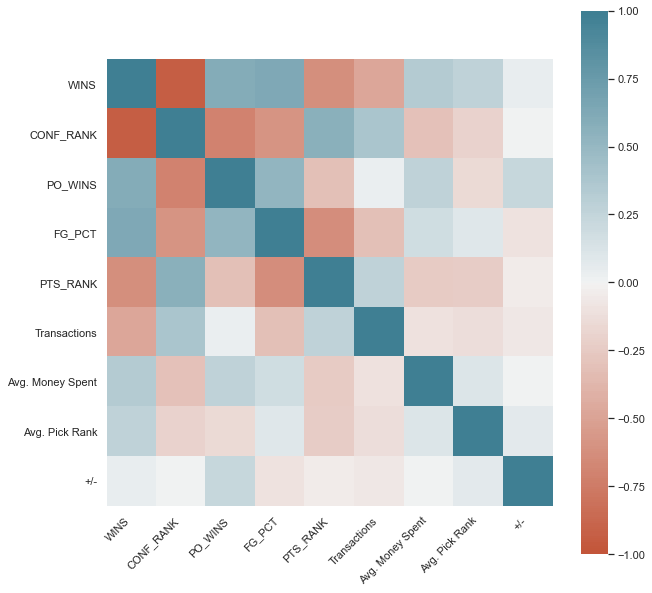

In [476]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Performing T-tests

T-test formula :
\begin{equation}
t = \frac{r\sqrt{n-2}}{\sqrt{1-r^2}}
\end{equation}

## Checking Normality

DescribeResult(nobs=90, minmax=(15.0, 60.0), mean=37.43333333333333, variance=132.58539325842696, skewness=-0.17990782372138844, kurtosis=-0.9507044196212489)
DescribeResult(nobs=90, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
DescribeResult(nobs=90, minmax=(26, 96), mean=54.544444444444444, variance=224.58789013732832, skewness=0.5384926008077048, kurtosis=-0.31189564486038623)
DescribeResult(nobs=90, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
DescribeResult(nobs=90, minmax=(3.03, 205.42), mean=33.056888888888885, variance=1416.2639385268415, skewness=1.9540676507176407, kurtosis=4.179165369507139)


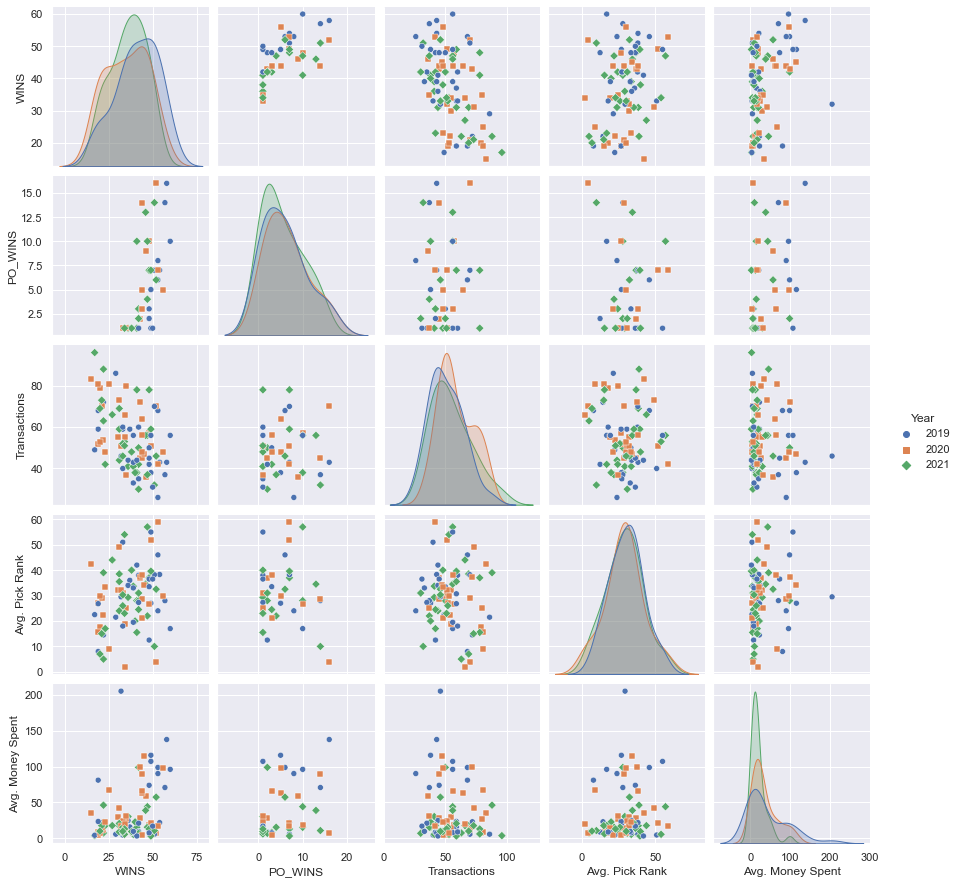

In [478]:
sns.pairplot(hue='Year', markers=["o", "s", "D"],
             data=dt[['Year', 'WINS', 'PO_WINS', 'Transactions', 'Avg. Pick Rank', 'Avg. Money Spent']])
print(stats.describe(dt['WINS']))
print(stats.describe(dt['PO_WINS']))
print(stats.describe(dt['Transactions']))
print(stats.describe(dt['Avg. Pick Rank']))
print(stats.describe(dt['Avg. Money Spent']))

## Regular Season Wins/Playoff Vs. Money Spent Within a Season

## Regular Season Wins/Playoff Wins Vs. Avg. Pick Rank

## Regular Season Wins/Playoff Wins Vs. Number of Transactions Within a Season

<AxesSubplot:xlabel='WINS', ylabel='Count'>

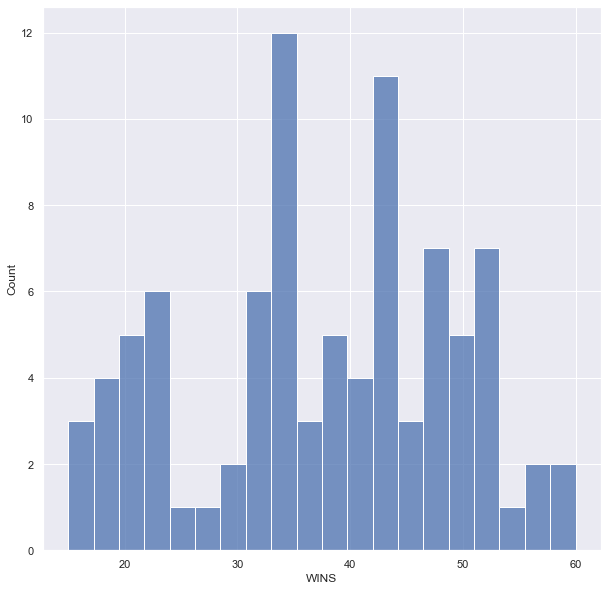

In [133]:
sns.histplot(data=dt, x='WINS', bins=20)

<AxesSubplot:xlabel='Transactions', ylabel='Count'>

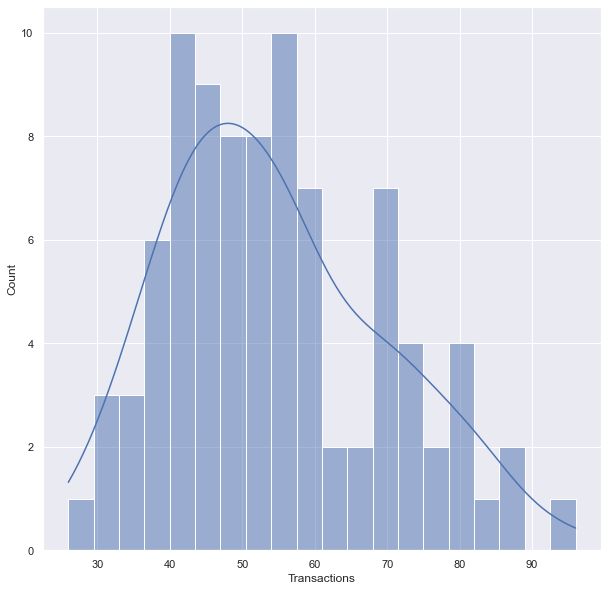

In [127]:
sns.histplot(data=dt, x='Transactions', bins=20, kde=True)